```
    __          ____  ___       __          __  
   / /   ____  / __ \/   |     / /   ____ _/ /_
  / /   / __ \/ /_/ / /| |    / /   / __ `/ __ \
 / /___/ /_/ / _, _/ ___ |   / /___/ /_/ / /_/ /
/_____/\____/_/ |_/_/  |_|  /_____/\__,_/_.___/
                                                
```

*Written by [Déreck Piché](https://dereckpiche.github.io) for [AIMS](https://en.wikipedia.org/wiki/African_Institute_for_Mathematical_Sciences).*


## References and Librairies

- [Original LoRA Paper](https://arxiv.org/abs/2106.09685)
- [Parameter-Efficient LLM Finetuning With Low-Rank Adaptation (LoRA) by Sebastian Raschka](https://sebastianraschka.com/blog/2023/llm-finetuning-lora.html)
- [Practical Tips for Finetuning LLMs Using LoRA (Low-Rank Adaptation)](https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms)

In [1]:
# remember that you can use the "%pip install library-name" command inside a jupyter environment cell.
!pip install datasets;
import flax.nnx as nnx; import jax; import jax.numpy as jnp; import jax; import jax.numpy as jnp; from flax import nnx; import optax; import numpy as np; from datasets import load_dataset; from transformers import AutoTokenizer; import torch; import matplotlib.pyplot as plt; import time; import pylab as pl; from IPython import display; import copy; import psutil; import pynvml

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Introduction

Learning is often more effective when new information is integrated with prior knowledge, rather than acquired in isolation. This principle underlies the widespread use of transfer learning, where models pre-trained on large corpora are adapted to new tasks. By leveraging such pre-trained representations, one can reduce the computational cost and data requirements typically associated with training models from scratch.

Low-Rank Adaptation (LoRA) provides a resource-efficient mechanism for fine-tuning large models. Instead of updating the full weight matrices or a fixed subset of parameters, LoRA introduces trainable low-rank matrices that modify the original weights in a structured manner. Specifically, weight updates are expressed as:

$$
W \leftarrow W + BA, \quad \text{where } A \in \mathbb{R}^{r \times n} \text{ and } B \in \mathbb{R}^{n \times r}
$$

This formulation allows for a substantial reduction in trainable parameters when $r \ll n$, thus decreasing the memory footprint and computational burden of fine-tuning.

In practice, the learning rate for LoRA updates in large language models (LLMs) is often set empirically to $ \alpha = 2r $. While this value is not derived from first principles, it serves as a practical heuristic. As with many hyperparameters in deep learning, its optimality is task- and model-dependent, and should be treated as a starting point rather than a fixed rule.

As for initialization, $A$ is initialized with a regular method and $B$ to a 0. This is so that we don't lose all of the prior knowledge of the pre-trained model. Then the first gradient for $A$ will be zero, and the first gradient for $B$ will be non-zero, which means the second gradient for $A$ will be non-zero. If both are initialized to zero, the gradients will always be zero and therefore no training will be performed.


## Motivation

### Motivation Part 1: Empirical Observation
We will first show empirically that the weight updates in a finetuned model have lower rank than their pretraining counterparts.

#### Sidenote: How to Approximate the Rank
Recall that for a matrix of shape $m \times n$, the following holds:

$$
n = \text{Rank}(A) + \text{Nullity}(A)
$$

Here, $\text{Nullity}(A)$ is the dimension of the null space of $A$, which corresponds to the multiplicity of the zero eigenvalue.

So, if we can approximate the spectrum of a matrix, we can estimate its rank by counting the number of eigenvalues below some small threshold $\epsilon$.

The spectrum can be estimated iteratively using any algorithm that approximates the SVD decomposition:

$$
A \approx U \Sigma V^{\top}
$$

Since the spectrum is given by the diagonal entries of $\Sigma$ in the SVD, this gives a practical way to measure approximate rank.


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
pretrained = "HuggingFaceTB/SmolLM2-135M"
instruct = "HuggingFaceTB/SmolLM2-135M-Instruct"

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M-Instruct")
device = "cpu"
pretrained = AutoModelForCausalLM.from_pretrained(pretrained, cache_dir="models").to(device).state_dict()
instruct = AutoModelForCausalLM.from_pretrained(instruct, cache_dir="models").to(device).state_dict()

In [3]:
assert pretrained.keys() == instruct.keys()
def get_rank(matrix, tolerance=5e-2):
    n, _ = matrix.shape
    u, s, vh = jnp.linalg.svd(matrix)
    rank = m - sum(s<tolerance)
    return rank
tensor_path = "model.layers.0.self_attn.q_proj.weight"
w = jnp.array(pretrained[tensor_path])
n, m = w.shape
w_updated = jnp.array(instruct[tensor_path])
Δw = w_updated - w
w_rank = get_rank(w)
Δw_rank = get_rank(Δw)
text = f""" \
    Let W = {tensor_path}. \n \
    As the path indicates, this is the query matrix of the first layer. \n \
    This query weight matrix has a shape of {n} x {n}. \n \
    The rank of W is ~= {w_rank} \n \
    The rank of ΔW is ~= {Δw_rank}. \n \
    The ratio of the ranks if ~= {Δw_rank/w_rank:.2f}."""
print(text)

     Let W = model.layers.0.self_attn.q_proj.weight. 
     As the path indicates, this is the query matrix of the first layer. 
     This query weight matrix has a shape of 576 x 576. 
     The rank of W is ~= 542 
     The rank of ΔW is ~= 315. 
     The ratio of the ranks if ~= 0.58.


### Motivation Part 2: Advantages

#### 1) Reduced vRAM for Adaptative Optimizers

The memory requirements are drastically improved for modern optimizers like Adam. Indeed, recall that Adam needs to store the first and second moment of the gradient tensors. The memory requirements for each LoRA tensors are thus reduced from $2 n^2$ to $4nk$.


#### 2) 25% Training Speedup: Computing the Number of Required Operations in the Backward Pass

The authors of LoRA report a 25% training speed up. The authors do not provide the details as to why this is the case.

However, we do:

Suppose  
$$ B \in \mathbb{R}^{d \times r}, \quad A \in \mathbb{R}^{r \times d}, \quad x \in \mathbb{R}^d. $$

LoRA will change our forward pass mappings to  
$$ (W + BA)x. $$  
$BA$ is of rank $k$.

There are no significant changes in computational time during the forward pass. However, the backward pass can be faster.

From matrix calculus, if we have a function  
$$ L : \mathbb{R}^n \rightarrow \mathbb{R}, $$  
then  
$$ \nabla_W L(Wx) = \nabla_z L \, x^\top, \quad \text{where } z := Wx. $$
This gradient will take $nr$ operations to compute.

Note that here, the gradient definition is the one from the deep learning auto-differentiation community, where the shape of $\nabla_T L$ is equal to the shape of $T$, since $L$ is always assumed to map to a scalar.

We now wish to find the gradients of $B$ and $A$. From the rule above, it is the case that  
$$ \nabla_B L = \nabla_z L \times (Ax)^\top, \quad \text{with } z := BAx. $$

The gradient of $A$ is different. We have
\begin{align}
\frac{\partial L}{\partial A_{i,j}} = \sum_{k} \frac{\partial L}{\partial z_{k}} \frac{\partial z_{k}}{\partial A_{i,j}}
\end{align}
and 

\begin{align}
z_{k} = 
\sum_{j} \sum_{l} B_{k,l} A_{l,j} x_{j}
\implies
\frac{\partial z_{k}}{\partial A_{i,j}} = B_{k,i} x_{j}
\end{align}

therefore

\begin{align}
\frac{\partial L}{\partial A_{i,j}} = \sum_{k} \frac{\partial L}{\partial z_{k}} B_{k,i} x_{j}
= x_{j} \sum_{k} B_{i,k}^\top \frac{\partial L}{\partial z_{k}} 
= x_{j} \left[B^\top \nabla_z L\right]_{i}
\end{align}
which means 
\begin{align}
\nabla_A L = B^\top \ \nabla_z L \ x^\top
\end{align}

We have $\nabla_z L \in \mathbb{R}^{d}$ and $B^\top \in \mathbb{R}^{r \times d}$ so that $h = B^\top \ \nabla_z L$ requires $nr$ operations and $h x^\top \in \mathbb{R}^{r \times d}$ requires $nr$ operations as well.

And so, with rank $r$, LoRA requires  $ 3nr $ overhead computations as opposed to  $ n^2. $

Note that most of these operations are linear, so they can be parallelized. This means that with sufficient GPU memory, there is no gain in performance in the backward pass.  




#### 3) Others
- No added inference time. The LoRA weights can be merged to the original weights.
- Using a prompt to change the behavior of the model is high cost.


## Implementation

### A Quick Prequel: Generalization to Batched Linear Maps

Recall that any linear mapping from a tensor of shape $S$ to a tensor of shape $S'$ can be expressed in vectorized form. Let $s := \prod_{i} S_i$ and $s' := \prod_{j} S'_j$, then the transformation is equivalent to applying a matrix $W \in \mathbb{R}^{s \times s'}$.

Now, recall that canonical LoRA proposes to update this weight matrix using:

$$
\Delta W = BA, \quad B \in \mathbb{R}^{s \times r}, \; A \in \mathbb{R}^{r \times s'}
$$

Therefore, LoRA can be generalized to any linear mapping $F: S \to S' $ with a pair of linear maps $A: S \to r$ and $B: r \to S'$.


(Warning: what follows is just my opinion.)

That said, LoRA is just one way to implement low-rank updates—there are more flexible variants. For instance, using the same rank $r$ for all linear maps in a model may be overly simplistic.

Consider this alternative: we know that the maximal rank of $W$ is $r_{\text{max}} = \min(s, s')$. Then, we can define a global hyperparameter $\rho \in [0,1]$ and set the rank individually as:

$$
r = \lceil \rho \cdot r_{\text{max}} \rceil
$$

In this formulation, $\rho = 1$ corresponds to full-rank training, while smaller values of $\rho$ induce greater parameter efficiency.


### Implementation Part 1: Basic GPT Implementation
This part can be skipped, as it does not relate directly to LoRA.


In [4]:
class TransformerBlock(nnx.Module):
    """
    This class implements a transformer block.
    Args:
        embed_dim: The dimension of the embeddings.
        num_heads: The number of attention heads.
        ff_dim: The dimension of the feedforward network.
        dropout_rate: The dropout rate.
        rngs: The random number generator to use.
    """
    def __init__(self,
                 embed_dim,
                 num_heads,
                 ff_dim,
                 dropout_rate=0.1,
                 rngs=jax.random.key(0)):
        super().__init__()
        self.attn = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=embed_dim,
            dropout_rate=dropout_rate,
            rngs=rngs
        )
        self.ffn = nnx.Sequential(
            nnx.Linear(embed_dim, ff_dim, rngs=rngs), nnx.gelu,
            nnx.Linear(ff_dim, embed_dim, rngs=rngs)
        )
        self.ln1 = nnx.LayerNorm(embed_dim, rngs=rngs)
        self.ln2 = nnx.LayerNorm(embed_dim, rngs=rngs)
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
    def __call__(self, x, deterministic=False, decode=False):
        batch_size, seq_len, embed_dim = x.shape
        attn_input = self.ln1(x)
        mask = nnx.make_causal_mask(
            jnp.zeros((batch_size, seq_len)))
        attn_output = self.attn(
            attn_input, attn_input, attn_input,
            mask=mask,
            decode=decode,
            deterministic=deterministic
        )
        x = x + self.dropout(attn_output,
                             deterministic=deterministic)
        ffn_input = self.ln2(x)
        ffn_output = self.ffn(ffn_input)
        x = x + self.dropout(ffn_output,
                             deterministic=deterministic)
        return x
class GPT(nnx.Module):
    """
    This class implements a GPT model.
    Args:
        vocab_size: The size of the vocabulary.
        embed_dim: The dimension of the embeddings.
        num_layers: The number of layers in the model.
        num_heads: The number of attention heads.
        ff_dim: The dimension of the feedforward network.
        max_seq_len: The maximum sequence length. (For positional encoding)
        dropout_rate: The dropout rate.
        rngs: The random number generator to use.
    """
    def __init__(self,
                 vocab_size,
                 embed_dim,
                 num_layers,
                 num_heads,
                 ff_dim,
                 max_seq_len,
                 dropout_rate=0.1,
                 rngs=jax.random.key(0)):
        super().__init__()
        self.embedding = nnx.Embed(vocab_size,
                                   embed_dim,
                                   rngs=rngs)
        self.pos_embedding = nnx.Embed(max_seq_len,
                                       embed_dim,
                                       rngs=rngs)
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
        self.blocks = [TransformerBlock(embed_dim,
                                        num_heads,
                                        ff_dim,
                                        dropout_rate,
                                        rngs=rngs)
                     for _ in range(num_layers)]
        self.ln_final = nnx.LayerNorm(embed_dim, rngs=rngs)
        self.head = nnx.Linear(embed_dim, vocab_size, rngs=rngs)
    def __call__(self, x, deterministic=False, decode=False):
        batch_size, seq_len = x.shape
        positions = jnp.arange(seq_len)[None, :]
        x = self.embedding(x) + self.pos_embedding(positions)
        x = self.dropout(x, deterministic=deterministic)
        for block in self.blocks:
            x = block(x, deterministic=deterministic, decode=decode)
        x = self.ln_final(x)
        logits = self.head(x)
        return logits
key = jax.random.PRNGKey(0)
params_key, dropout_key = jax.random.split(key)
rngs = nnx.Rngs(params=params_key, dropout=dropout_key)
config = {
    "vocab_size": 30522,
    "embed_dim": 32,
    "num_layers": 32,
    "num_heads": 8,
    "ff_dim": 32,
    "max_seq_len": 10000,
    "dropout_rate": 0.01, "rngs": rngs
}
model = GPT(**config); model_2 = GPT(**config)
# Generate sample input
batch_size = 14; seq_len = 28
x = jax.random.randint(key=jax.random.key(0),
                       shape=(batch_size, seq_len),
                       minval=1, maxval=config['vocab_size'])
logits = model(x, deterministic=True)

### Implementation Part 2: LoRA Wrappers

In [5]:
from flax.nnx.nn import initializers
class LoRAwrapper(nnx.Module):
    """
    A wrapper for the Matrix in a nnx.Linear layer.
    """
    def __init__(self,
                 module,
                 a_initializer=initializers.he_uniform(),
                 b_initializer=initializers.zeros,
                 rank=8,
                 alpha=1,
                 rngs : nnx.Rngs =nnx.Rngs(0)
                 ):
        super().__init__()
        assert isinstance(module, (nnx.Linear, nnx.LinearGeneral))
        in_features = module.in_features
        out_features = module.out_features
        lora_A_key=rngs
        lora_B_key=rngs
        if isinstance(module, nnx.Linear):
            self.lora_A = nnx.Linear(in_features=in_features,
                                        out_features=rank,
                                        kernel_init=a_initializer,
                                        use_bias=False,
                                        rngs=lora_A_key)
            self.lora_B = nnx.Linear(in_features=rank,
                                        out_features=out_features,
                                        kernel_init=b_initializer,
                                        use_bias=False,
                                        rngs=lora_B_key)
        if isinstance(module, nnx.LinearGeneral):
            if isinstance(in_features, int): in_features = [in_features]
            if isinstance(out_features, int): out_features = [out_features]
            self.lora_A = nnx.LinearGeneral(in_features=in_features,
                                            out_features=rank,
                                            kernel_init=a_initializer,
                                            axis=module.axis,
                                            use_bias=False,
                                            rngs=lora_A_key)
            self.lora_B = nnx.LinearGeneral(in_features=rank,
                                            kernel_init=b_initializer,
                                            out_features=out_features,
                                            use_bias=False,
                                            rngs=lora_B_key)
        self.module = module
        self.alpha = alpha
    def __call__(self, x):
        return self.module(x) + self.lora_B(self.lora_A(x))

### Implementation Part 3: Applying LoRA with filters

We want to implement our LoRA adapters as wrappers that can be applied post architecture definition. In order to do this, we will need to perform what is refered to as "model surgery" in JAX. Our method will be as follows: we will iterate on the module of the model instance, pattern match on some aspects of the module paths, and wrap LORA adapters on the corresponding modules.

In [6]:
c = 0
for path, module in model.iter_modules():
    c += 1
    if c > 10: print("...");break
    print(path)

('blocks', 0, 'attn', 'key')
('blocks', 0, 'attn', 'out')
('blocks', 0, 'attn', 'query')
('blocks', 0, 'attn', 'value')
('blocks', 0, 'attn')
('blocks', 0, 'dropout')
('blocks', 0, 'ffn', 'layers', 0)
('blocks', 0, 'ffn', 'layers', 2)
('blocks', 0, 'ffn')
('blocks', 0, 'ln1')
...


#### The `lora_choice` methods

These functions define *LoRA selection policies* — i.e., rules for determining whether a given module in a model should be wrapped with a LoRA (Low-Rank Adaptation) layer, and if so, what configuration it should use.

They are designed to be passed into model surgery tools that traverse a model's parameter/module tree and apply LoRA selectively.

Each function takes as input:

- **`path`** (`str`): A string representation of the module's hierarchical name or path within the model. This is typically derived from tree-traversal utilities (e.g., in `flax`, `nnx`, or `elegy`) and is useful for pattern-matching specific submodules like `"attention.value"` or `"mlp.1.linear"`.

- **`module`** (`nnx.Module` or subclass): The actual module instance at the given path. Usually this will be a subclass of `nnx.Linear`, `nnx.LinearGeneral`, or some other neural network layer. It can be inspected for shape, type, or other properties to make dynamic decisions (e.g. based on output dimensionality).

Return value (for all functions):  
A tuple of the form `(should_apply: bool, config: dict)`:
- `should_apply`: `True` if this module should be LoRA-wrapped, `False` otherwise.
- `config`: If `True`, this provides:
  - A dictionary of LoRA hyperparameters (`rank`, `alpha`, `a_initializer`, `b_initializer`, etc.)


In [7]:
def classic_lora_choice(path,
                        module,
                        targets=["value"],
                        rank=16,
                        alpha=32,
                        a_initializer=initializers.he_uniform(),
                        b_initializer=initializers.zeros):
    kwargs = {"rank": rank,
              "alpha": alpha,
              "a_initializer": a_initializer,
              "b_initializer": b_initializer}
    for target in targets:
        if target in path: return True, kwargs
    return False, {}

def all_linear_lora_choice(path,
                        module,
                        rank=16,
                        alpha=32,
                        a_initializer=initializers.he_uniform(),
                        b_initializer=initializers.zeros):
    if isinstance(module, (nnx.LinearGeneral, nnx.Linear)):
        kwargs = {"rank": rank,
              "alpha": alpha,
              "a_initializer": a_initializer,
              "b_initializer": b_initializer}
        return True, kwargs
    return False, {}

def rho_lora_choice(path,
                    module,
                    rho=0.5,
                    alpha=32,
                    a_initializer=initializers.he_uniform(),
                    b_initializer=initializers.zeros):

    if isinstance(module, (nnx.LinearGeneral, nnx.Linear)):
        s = np.prod(module.in_features)
        s_prime = np.prod(module.out_features)
        import math
        lora_rank = math.ceil(rho * min(s, s_prime))
        kwargs = {"rank": lora_rank,
              "alpha": alpha,
              "a_initializer": a_initializer,
              "b_initializer": b_initializer}
        return True, kwargs
    return False, {}

#### Iterate the Model and Apply LoRA

In [8]:
def apply_lora_wrappers(
    model,
    lora_choice_method,
    rngs : nnx.Rngs = nnx.Rngs(0)
):
    """
    This wraps a model with LoRA weights using a lora_choice method.

    Args:
        model: The model to add LoRA weights to. This should support
            `.iter_modules()` for recursive traversal (e.g., nnx models).

        lora_choice_method: A function with signature
            (path: List[Union[str, int]], module: nnx.Module) -> Tuple[bool, dict].
            It determines whether a given module should be replaced with
            a LoRA-wrapped version, and if so, returns a dictionary of
            configuration arguments for the LoRA wrapper.

            The `path` is a list representing the hierarchical location of the
            module in the model tree (e.g., ["encoder", "layers", 0, "self_attn", "value"]).
            The `module` is the actual nnx.Module instance at that location.

            Return:
                - should_wrap (bool): If True, the module is replaced with a
                  LoRA-wrapped version.
                - kwargs (dict): A dictionary of keyword arguments to pass to the
                  `LoRAwrapper`, such as `rank`, `alpha`, and initializers.
    """
    working_model = model
    for path, module in list(working_model.iter_modules()):
        should_wrap, kwargs = lora_choice_method(path, module)
        if should_wrap \
        and isinstance(module, (nnx.LinearGeneral, nnx.Linear)):
            lora_module = LoRAwrapper(module, **kwargs, rngs=rngs)
            current = working_model
            for step in path[:-1]:
                if isinstance(step, int): current = current[step]
                else: current = getattr(current, step)
            if isinstance(path[-1], int):current[path[-1]] = module
            else: setattr(current, path[-1], lora_module)

In [9]:
# Get basic GPT model
print("Original Model")
import time
time.sleep(0.5)
model = GPT(**config)
out_before_lora = model(x, deterministic=True)[0, 0]
nnx.display(model)
targets = ["nnx.LinearGeneral"]


# Apply LoRA to the model
print("Model with LoRA")
import time
time.sleep(0.5)
apply_lora_wrappers(model,
                    lora_choice_method=classic_lora_choice)
out_after_lora = model(x, deterministic=True)[0, 0]
nnx.display(model)

# Check if original weights are intact
no_weights_changed = jnp.mean(out_before_lora - out_after_lora) < 1e-6
print("\n\n\n", "Original Weights Are Intact: ", no_weights_changed)

Original Model


Model with LoRA





 Original Weights Are Intact:  True


### Impementation Part 4: LoRA Methods

Now that various Transformer architectures can be injected with LoRA weights, we can add more utils. We should have methods to 1) remove the LoRA weights, 2) get the LoRA params and 3) merge the LoRA weights to their associated tensors.

#### Filter the LoRA params
When performing gradient descent, we only need the gradient with respect to the LoRA parameters. JAX allows us to specify on which modules to differentiate by using filters. An in-depth guide is provided at [NNX's Filter Guide](https://flax.readthedocs.io/en/latest/guides/filters_guide.html). See also the second example of [the grad method](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.grad). Indeed, `nnx.grad` takes an `argnums` argument which specifies which arguments of `f` should be differentiated. For instance, `nnx.grad(f, argnums=1)(x,y,z)` will differentiate `f` with respect to `y`. However, we can also set `argnums=nnx.DiffState(1, filter)`, which will differentiate the components of `y` that get filtered by `filter`. A filter needs to be of the form `(path: tuple[Key, $.], value: Any) -> bool`.

Furthermore, when using an optimizer like Adam, only the running averages of the mean gradients for the LoRA weights should be stored. `nnx.Optimizer` has a `wrt` (with respect to) argument that allows the user to specify which parts of the model graph should be stored.

In [10]:
def lora_filter(path, value): return "lora_A" in path or "lora_B" in path

In [11]:

def get_lora_grad(model, lossf, *kwargs):
    """
    This function returns the gradient of the loss function with respect to the LoRA parameters.
    Args:
        model: The model to train.
        lossf: The loss function.
        kwargs: Additional arguments to pass to the loss function.
    """
    return nnx.grad(lossf, argnums=nnx.DiffState(0, lora_filter))(model, *kwargs)

In [12]:
def get_lora_params(model):
    """
    This function returns the LoRA parameters from the model.
    Args:
        model: The model to get the LoRA parameters from.
    """
    lora_params = nnx.state(model, lora_filter)
    return lora_params

#### Merge the LoRA Weights

In Flax's `nnx.LinearGeneral` module, the underlying kernel of the linear maps have shape (in_features..., out_features...). Therefore, the kernel of `lora_A` will have shape (in_features, r) and `lora_B` (r, out_features...). To get the kernel of the composition, we can simply use a `jax.Einsum` on the  `r` axis.

In [13]:
def merge_lora_weights(
    model
):
    """
    TODO
    This function merges the LoRA weights to the original weights.
    Args:
        model: The model to merge the LoRA weights to.
    """
    working_model = model
    for path, module in list(working_model.iter_modules()):
        if isinstance(module, LoRAwrapper):
            current = working_model
            for step in path[:-1]:
                if isinstance(step, int):
                    current = current[step]
                else:
                    current = getattr(current, step)
            regular_kernel = module.module.kernel.value
            lora_a_kernel = module.lora_A.kernel.value
            lora_b_kernel = module.lora_B.kernel.value
            nb_in_axes_A = len(lora_a_kernel.shape)-1
            nb_in_axes_B = len(lora_b_kernel.shape)-1
            in_axes_A = "".join([chr(105 + i) for i in range(nb_in_axes_A)])
            out_axes_B = "".join([chr(105 + nb_in_axes_A + i) for i in range(nb_in_axes_B)])
            einsum_str = f"{in_axes_A}r,r{out_axes_B}->{in_axes_A}{out_axes_B}"
            kernel_update = jnp.einsum(einsum_str, lora_a_kernel, lora_b_kernel)
            # Change the original kernel
            setattr(module.module.kernel, "value", regular_kernel + kernel_update)
            # Remove LoRA Wrapper
            setattr(current, path[-1], getattr(current, path[-1]).module)

# Get LoRA model
model = GPT(**config)
apply_lora_wrappers(model,
                    lambda path, module : classic_lora_choice(path, module, b_initializer=initializers.he_uniform()))


print("Kernel before merging:")
nnx.display(model.blocks[0].attn.value.module.kernel.value)
out_one = model(x, deterministic=True)

merge_lora_weights(model)
out_after_merge = model(x, deterministic=True)
print("Kernel after merging:")
nnx.display(model.blocks[0].attn.value.kernel.value)

print("Sample outputs are the same after merging:", np.mean(np.abs(out_one - out_after_merge)) < 1e-6)

Kernel before merging:


Kernel after merging:


Sample outputs are the same after merging: True


In [14]:
def switch_lora_weights(
    model,
    lora_params,
    ):
    """
    This function switches the LoRA weights of a model.
    Args:
        model: The model to switch the LoRA weights to.
        lora_params: The LoRA parameters to switch to.
    """
    working_model = model
    for path, value in lora_params.flat_state().items():
        if (('lora_A' in path or 'lora_B' in path) and path[-1] == 'kernel'):
            current = working_model
            new_lora = lora_params
            for step in path:
                if isinstance(step, int):
                    current = current[step]
                    new_lora = new_lora[step]
                else:
                    current = getattr(current, step)
                    new_lora = getattr(new_lora, step)
            original_lora_kernel = getattr(new_lora, 'value')
            new_lora_kernel = getattr(current, 'value')
            original_lora_kernel = new_lora_kernel


model = GPT(**config)
apply_lora_wrappers(model, classic_lora_choice, rngs=nnx.Rngs(0))
nnx.display(model.blocks[0].attn.value.lora_A.kernel.value)
model2 = GPT(**config)
apply_lora_wrappers(model2, classic_lora_choice, rngs=nnx.Rngs(1))
nnx.display(model2.blocks[0].attn.value.lora_A.kernel.value)
switch_lora_weights(model, get_lora_params(model2))
nnx.display(model.blocks[0].attn.value.lora_A.kernel.value)

## Quantifications





### 1) Number of parameters in the LoRA weights

We can get an idea of the number of parameters in the LoRA weights by varying the rank.

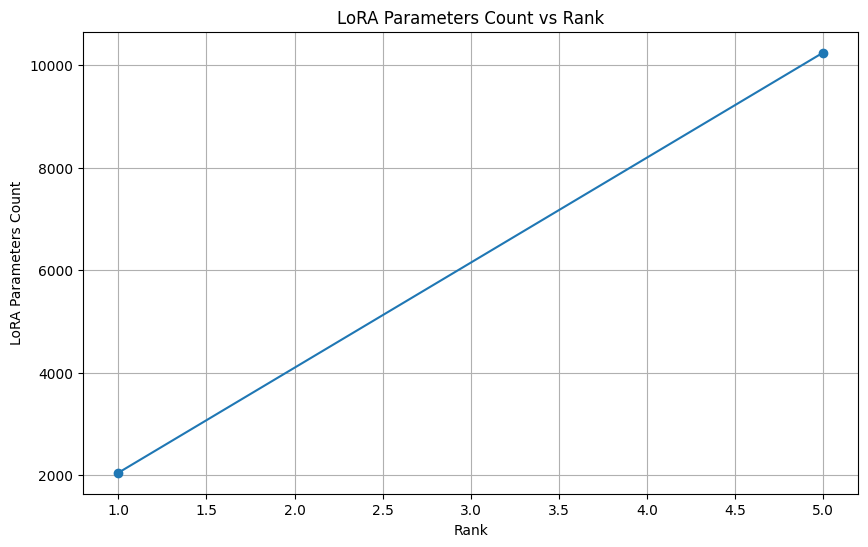

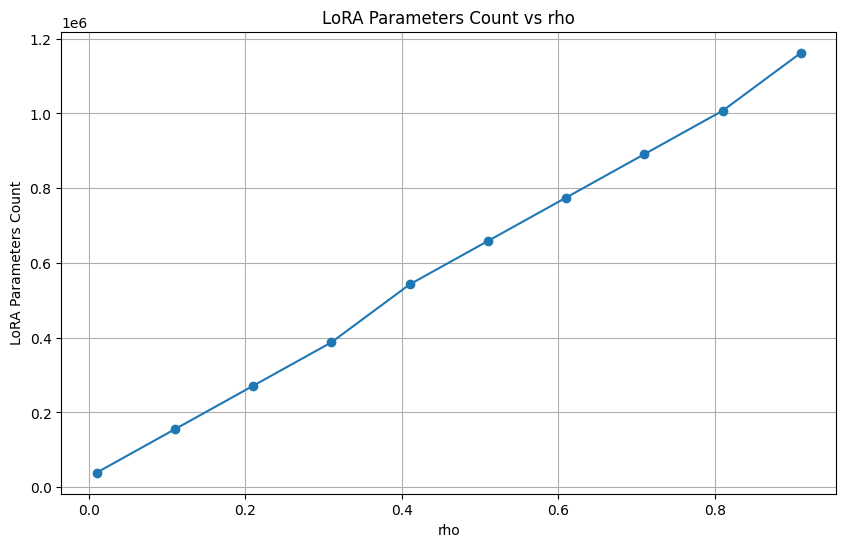

In [15]:
def get_lora_params_count(config, lora_choice):
    model = GPT(**config)
    apply_lora_wrappers(model,
                        lora_choice)
    def count_params(state):
        return sum(p.size for p in jax.tree_util.tree_leaves(state))
    return count_params(get_lora_params(model))

import matplotlib.pyplot as plt

ranks = []
param_counts = []

for r in [1, 5]:

    lora_choice = lambda path, module : classic_lora_choice(path, module, targets=["value"], rank=r)
    param_count = get_lora_params_count(config, lora_choice)
    ranks.append(r)
    param_counts.append(param_count)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(ranks, param_counts, marker='o')
plt.title('LoRA Parameters Count vs Rank')
plt.xlabel('Rank')
plt.ylabel('LoRA Parameters Count')
plt.grid(True)
plt.show()

rhos = np.arange(0.01, 1.0, 0.1)
param_counts = []
for rho in rhos:
    lora_choice = lambda path, module : rho_lora_choice(path, module, rho=rho, alpha=32)
    param_count = get_lora_params_count(config, lora_choice)
    param_counts.append(param_count)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(rhos, param_counts, marker='o')
plt.title('LoRA Parameters Count vs rho')
plt.xlabel('rho')
plt.ylabel('LoRA Parameters Count')
plt.grid(True)
plt.show()

### 2) Training Ressources

In [16]:
# Import training data
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # tokenizer.vocab_size = 30522
dataset = load_dataset("IsmaelMousa/books"); data = dataset['train']['EN']; books = data[0]
for i in range(1, len(data)): books += data[i]; ssl = 400
data = [books[i * ssl : (i+1) * ssl] for i in range(len(books)//ssl)]

In [17]:
def pretrain_transformer(transformer,
                        tokenizer,
                        data,
                        learning_rate=1e-3,
                        training_minutes=100,
                        train_full=False,
                        batch_size=32,
                        epochs=2000):
    import time
    import jax
    import jax.numpy as jnp
    import optax
    import psutil
    import matplotlib.pyplot as plt
    from IPython import display
    import numpy as np

    # Verify JAX devices
    print("JAX Devices:", jax.devices())
    # Check if a GPU is available
    gpu_available = any(dev.platform == 'gpu' for dev in jax.devices())

    time_start = time.time()
    losses = []
    cpu_usages = []
    times = []
    grad_times = []

    if train_full == False:
        optimizer = nnx.Optimizer(transformer, wrt=lora_filter, tx=optax.adam(learning_rate))
    else:
        optimizer = nnx.Optimizer(transformer, tx=optax.adam(learning_rate))

    def count_params(obj):
        state = nnx.state(obj)
        return sum(p.size for p in jax.tree_util.tree_leaves(state))

    num_model_params = count_params(transformer)
    num_optimizer_params = count_params(optimizer)

    def differentiable_loss(model, x, y):
        y_hat = model(x, deterministic=True)
        B, S, V = y_hat.shape
        y_hat = jnp.reshape(y_hat, [B*S, V]); y = jnp.reshape(y, [B*S])
        out_mask = (y != tokenizer.pad_token_id) & (y != tokenizer.sep_token_id)
        l = optax.softmax_cross_entropy_with_integer_labels(y_hat, y)
        l *= out_mask; l = jnp.sum(l) / jnp.sum(out_mask)
        return l

    plt.style.use('default')
    # Always use 3 subplots: loss, CPU usage, and gradient step time
    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    fig.subplots_adjust(hspace=0.6)

    # Flag to check devices only for the first batch
    first_batch = True

    for _ in range(epochs):
        i = 0
        while (i+1)*batch_size < len(data) and time.time() - time_start < training_minutes*60:
            cpu_usage = psutil.cpu_percent(interval=None)
            batch = data[i*batch_size: (i+1)*batch_size]
            enc = tokenizer.batch_encode_plus(batch, padding=True)
            ids = jnp.array(enc['input_ids'])
            x = jax.device_put(ids[:, :-1])
            y = jax.device_put(ids[:, 1:])

            # Assert that model parameters and data are on GPU if available, only for first batch
            if first_batch and gpu_available:
                state = nnx.state(transformer)
                params = jax.tree_util.tree_leaves(state)
                assert all(isinstance(p, jax.Array) and p.addressable_data(index=0).device.platform == 'gpu' for p in params), "Model parameters not on GPU"
                assert isinstance(x, jax.Array) and x.addressable_data(index=0).device.platform == 'gpu', "Data x not on GPU"
                assert isinstance(y, jax.Array) and y.addressable_data(index=0).device.platform == 'gpu', "Data y not on GPU"
                first_batch = False

            lossf = lambda model: differentiable_loss(model, x, y)
            loss = lossf(transformer)
            losses.append(float(loss))
            cpu_usages.append(cpu_usage)
            times.append(time.time() - time_start)

            # Measure gradient computation and update
            grad_start_time = time.time()
            if train_full == False:
                grad = get_lora_grad(transformer, lossf)
            else:
                grad = nnx.grad(lossf)(transformer)
            optimizer.update(grad)
            grad_time = time.time() - grad_start_time
            grad_times.append(grad_time)

            running_avg = np.cumsum(grad_times) / np.arange(1, len(grad_times) + 1)

            ax1, ax3 = axes

            ax1.clear()
            ax1.plot(times, losses, color='#2b83ba', linewidth=1.2)
            ax1.set_title('Loss', fontsize=10, pad=8, fontweight='bold')
            ax1.set_xlabel('Time (s)', fontsize=8)
            ax1.set_ylabel('Loss', fontsize=8)
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)
            ax1.tick_params(axis='both', labelsize=7)

            # ax2.clear()
            # ax2.plot(times, cpu_usages, color='#2b83ba', linewidth=1.2)
            # ax2.set_title('CPU Usage (%)', fontsize=10, pad=8, fontweight='bold')
            # ax2.set_xlabel('Time (s)', fontsize=8)
            # ax2.set_ylabel('CPU %', fontsize=8)
            # ax2.spines['top'].set_visible(False)
            # ax2.spines['right'].set_visible(False)
            # ax2.tick_params(axis='both', labelsize=7)

            ax3.clear()
            ax3.plot(times, grad_times, color='#2b83ba', linewidth=1.2, label='Per Step')
            ax3.plot(times, running_avg, color='#abdda4', linewidth=1.2, label='Running Avg')
            ax3.set_title('Gradient Step Time (s)', fontsize=10, pad=8, fontweight='bold')
            ax3.set_xlabel('Time (s)', fontsize=8)
            ax3.set_ylabel('Time (s)', fontsize=8)
            ax3.spines['top'].set_visible(False)
            ax3.spines['right'].set_visible(False)
            ax3.tick_params(axis='both', labelsize=7)
            ax3.legend(fontsize=8)

            param_text = f'Model Params: {num_model_params:,}\nOptimizer Params: {num_optimizer_params:,}'
            fig.suptitle(param_text, fontsize=10, y=0.98)

            fig.tight_layout()
            display.display(plt.gcf())
            display.clear_output(wait=True)
            i += 1

    plt.close(fig)

On the full model, we get:

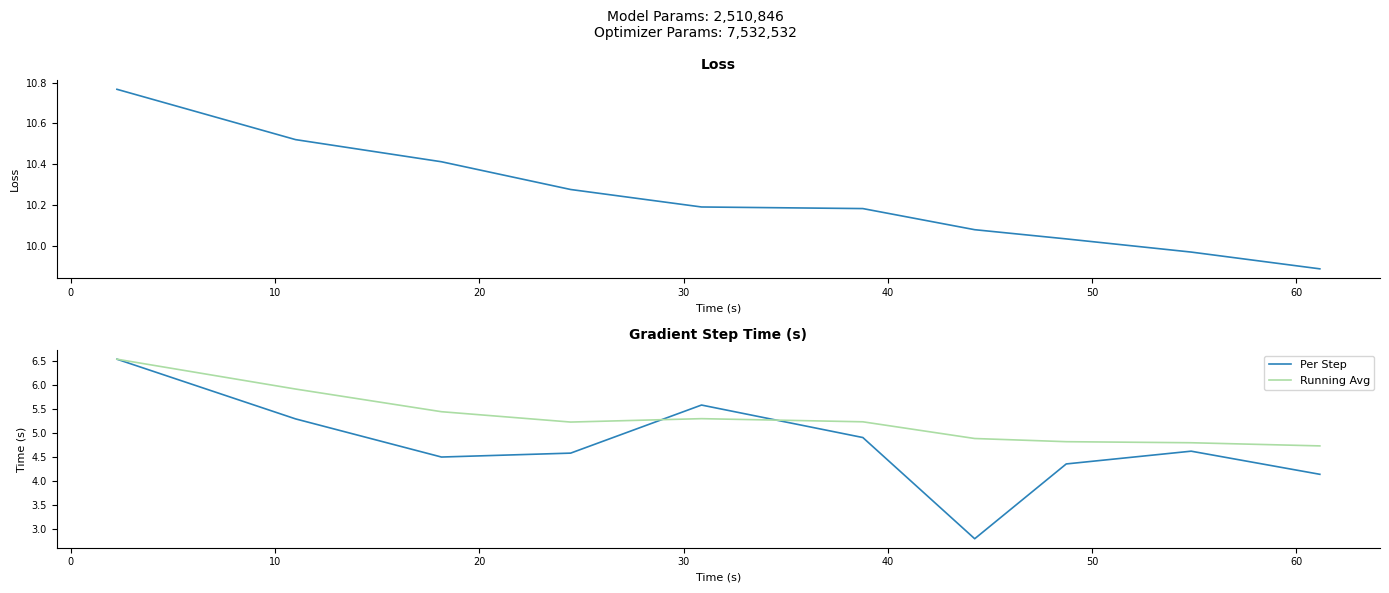

In [18]:
model = GPT(**config)
pretrain_transformer(transformer=model,
                     learning_rate=1e-3,
                     training_minutes=1,
                     batch_size=32,
                     train_full=True,
                     tokenizer=tokenizer,
                     data=data)

With only the value layer and rank $r$, we get:

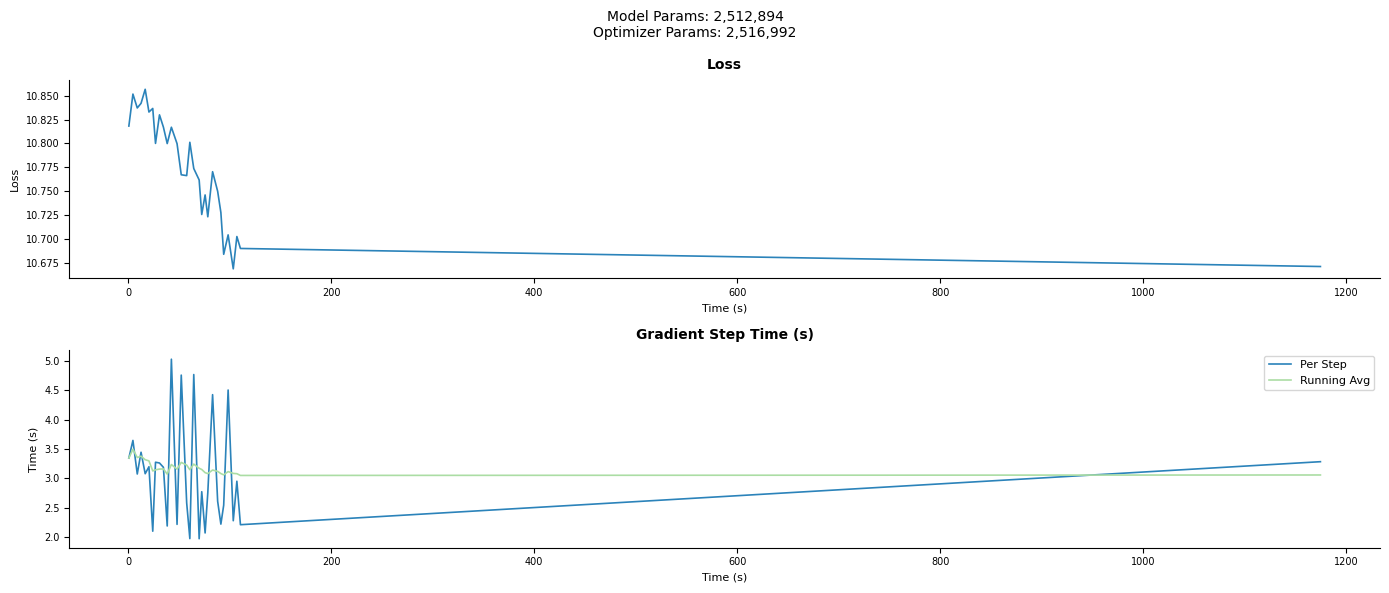

In [19]:
model = GPT(**config)
lora_choice = lambda path, module : classic_lora_choice(path, module, targets=["value"], rank=1)
apply_lora_wrappers(model, lora_choice)
pretrain_transformer(transformer=model,
                     learning_rate=1e-3,
                     training_minutes=5,
                     train_full=False,
                     tokenizer=tokenizer,
                     data=data)

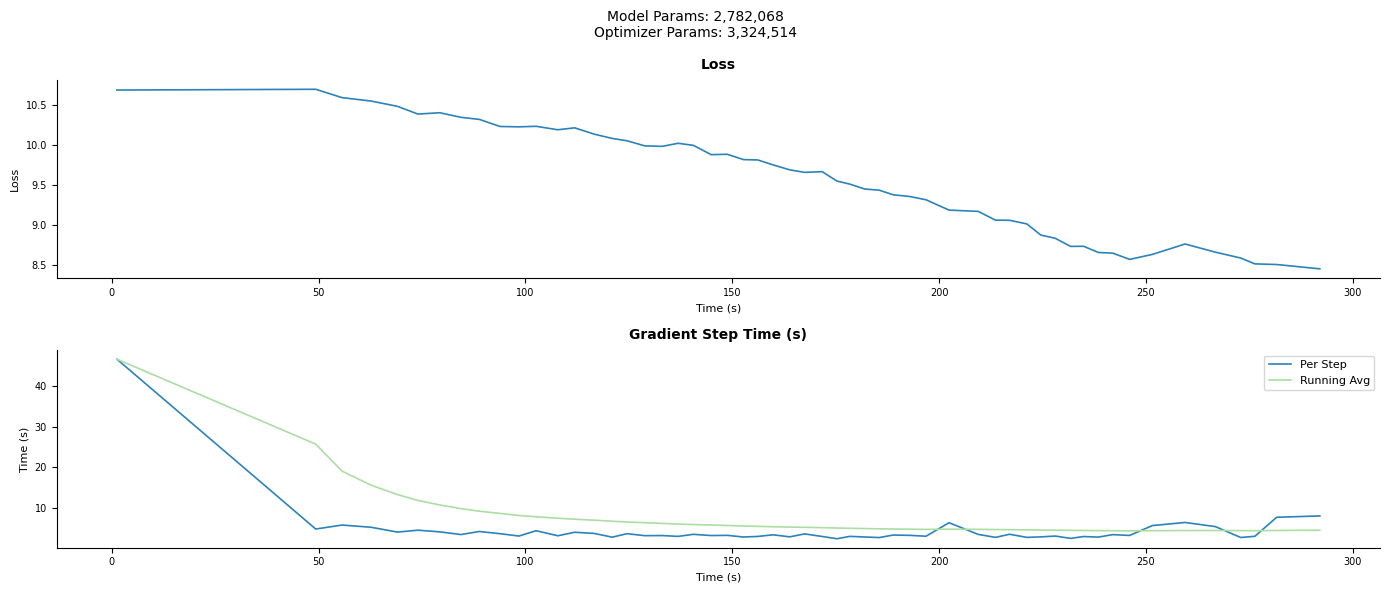

In [20]:
model = GPT(**config)
lora_choice = lambda path, module : rho_lora_choice(path, module, rho=0.2, alpha=32)
apply_lora_wrappers(model, lora_choice)
pretrain_transformer(transformer=model,
                     learning_rate=1e-3,
                     training_minutes=5,
                     train_full=False,
                     tokenizer=tokenizer,
                     data=data)